In [4]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from synthetic_datasets import BatchedInContextRecallDataset
from meta_optimizers import MetaSGD
from memory_module import inner_optimization_forward, TTT
from model_components import HyperparamModel, LearnableHyperparam


In [5]:
key_dim=10
val_dim=10
context_size=5 # inner loss computation window
seq_len=50
batch_size=100
recall_window=5 # for outer loss computation 
output_corr=0
inner_optimizer=MetaSGD()
#inner_optimizer_kwargs={"lr": torch.tensor(0.01), "beta": torch.tensor(0.9)}
outer_optimizer_kwargs={"lr": 0.01}

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# The inner model's parameters are the hidden state we meta-learn to update
inner_model = TTT(key_dim,val_dim,1)
inner_model = inner_model.to(device)

inner_opt = MetaSGD()
# Use global heads for simplicity; set in_dim=embed_dim if you want them context-dependent.
#lr_head = HyperparamModel(key_dim,-4.5)
#lr_head = lr_head.to(device)
lr_head = LearnableHyperparam().to(device)
loss_weight_head = torch.tensor([1.0, 1.0, 1.0, 1.0, 1.0]).to(device)  # Explicit 1D tensor


# Outer optimizer learns (1) the initial params of inner_model and (2) the heads
outer_optim = torch.optim.SGD(
    list(inner_model.parameters()) + list(lr_head.parameters()),
    **outer_optimizer_kwargs
)
num_steps = 1000

for step in range(num_steps):
    dataset = BatchedInContextRecallDataset(
        seq_len=seq_len,
        key_dim=key_dim,
        val_dim=val_dim,
        context_size=context_size,
        batch_size=batch_size,
    )

    outer_optim.zero_grad()
    loss, predictions = inner_optimization_forward(
        inner_model,
        dataset,
        inner_opt=inner_opt,
        lr_head=lr_head,
        loss_weight_head = loss_weight_head,
        outer_window_size=recall_window
    )
    loss.backward()
    outer_optim.step()

    if step % 100 == 0 or step == num_steps - 1:
        with torch.no_grad():
            weight_mean = torch.mean(torch.cat([w.flatten() for w in inner_model.weights])).item()
            weight_std = torch.std(torch.cat([w.flatten() for w in inner_model.weights])).item()
            #lr_val = lr_head(dataset.inputs[-1])
            lr_val = lr_head()
            print(f"step {step:4d} | loss {loss.item():.4f} | lr {lr_val.item():.4f} | inner params: weight_mean={weight_mean:.3f}, weight_std={weight_std:.3f}")

step    0 | loss 176.3297 | lr 0.1111 | inner params: weight_mean=-0.001, weight_std=0.019
step  100 | loss 157.3498 | lr 0.4702 | inner params: weight_mean=-0.001, weight_std=0.019
step  200 | loss 157.5851 | lr 0.4513 | inner params: weight_mean=-0.001, weight_std=0.019
step  300 | loss 157.3985 | lr 0.4647 | inner params: weight_mean=-0.001, weight_std=0.019
step  400 | loss 157.3682 | lr 0.4587 | inner params: weight_mean=-0.001, weight_std=0.019
step  500 | loss 157.4043 | lr 0.4637 | inner params: weight_mean=-0.001, weight_std=0.019
step  600 | loss 157.1860 | lr 0.4674 | inner params: weight_mean=-0.000, weight_std=0.018
step  700 | loss 157.1826 | lr 0.4740 | inner params: weight_mean=-0.000, weight_std=0.018
step  800 | loss 157.6731 | lr 0.4575 | inner params: weight_mean=-0.000, weight_std=0.018
step  900 | loss 157.3907 | lr 0.4637 | inner params: weight_mean=-0.000, weight_std=0.018
step  999 | loss 157.4109 | lr 0.4641 | inner params: weight_mean=-0.001, weight_std=0.018

Parameter: weights.0, Shape: torch.Size([10, 10]), Weights: 100
Parameter: biases.0, Shape: torch.Size([1, 10]), Weights: 10


/tmp/ipykernel_323335/819567303.py:66: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax4.boxplot(param_weights, labels=param_names)


<Figure size 1200x800 with 0 Axes>

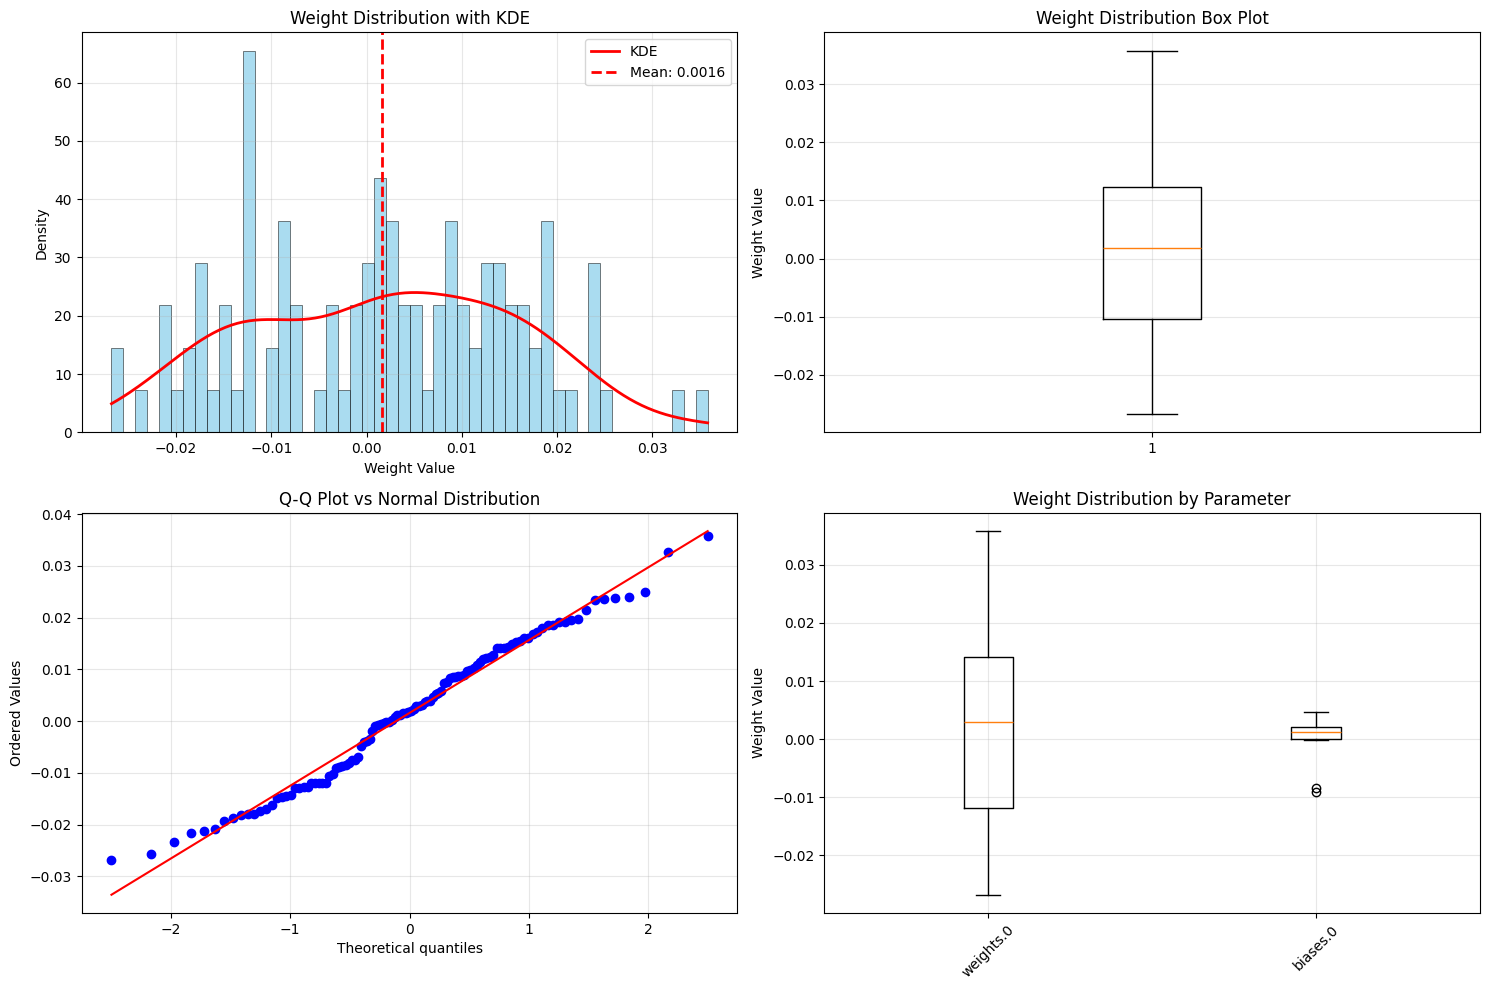

INNER MODEL WEIGHT DISTRIBUTION STATISTICS
Total weights: 110
Mean: 0.001598
Std:  0.013923
Min:  -0.026788
Max:  0.035815
Median: 0.001887
25th percentile: -0.010431
75th percentile: 0.012301

PARAMETER-SPECIFIC STATISTICS

weights.0:
  Shape: torch.Size([10, 10])
  Mean: 0.001777
  Std:  0.014521
  Count: 100

biases.0:
  Shape: torch.Size([1, 10])
  Mean: -0.000191
  Std:  0.004477
  Count: 10

COMPARISON WITH EXPECTED DISTRIBUTIONS
Expected initial std (from training): ~0.020
Actual final std: 0.013923
Std ratio (final/initial): 0.70x
Weights near zero (< 1e-06): 0/110 (0.00%)


In [4]:
# Extract all weights from the trained inner model (TTT)
all_weights = []

# Get all parameters from the trained TTT model
for param_name, param in inner_model.named_parameters():
    if param.requires_grad:  # Only include trainable parameters
        weights = param.detach().cpu().numpy().flatten()
        all_weights.extend(weights)
        print(f"Parameter: {param_name}, Shape: {param.shape}, Weights: {len(weights)}")

# Convert to numpy array for easier manipulation
all_weights = np.array(all_weights)

# Create the empirical distribution plot
plt.figure(figsize=(12, 8))

# Create subplots for better visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Histogram with KDE
n, bins, patches = ax1.hist(all_weights, bins=50, density=True, alpha=0.7, 
                           color='skyblue', edgecolor='black', linewidth=0.5)

# Add kernel density estimate if scipy is available
try:
    from scipy import stats
    kde = stats.gaussian_kde(all_weights)
    x_range = np.linspace(all_weights.min(), all_weights.max(), 200)
    ax1.plot(x_range, kde(x_range), 'r-', linewidth=2, label='KDE')
except ImportError:
    print("scipy not available, skipping KDE")

ax1.axvline(all_weights.mean(), color='red', linestyle='--', linewidth=2, 
           label=f'Mean: {all_weights.mean():.4f}')
ax1.set_xlabel('Weight Value')
ax1.set_ylabel('Density')
ax1.set_title('Weight Distribution with KDE')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Box plot
ax2.boxplot(all_weights)
ax2.set_ylabel('Weight Value')
ax2.set_title('Weight Distribution Box Plot')
ax2.grid(True, alpha=0.3)

# Plot 3: Q-Q plot to check normality
try:
    from scipy import stats
    stats.probplot(all_weights, dist="norm", plot=ax3)
    ax3.set_title('Q-Q Plot vs Normal Distribution')
    ax3.grid(True, alpha=0.3)
except ImportError:
    ax3.text(0.5, 0.5, 'Q-Q plot requires scipy', ha='center', va='center', transform=ax3.transAxes)
    ax3.set_title('Q-Q Plot (scipy not available)')

# Plot 4: Weight statistics over parameter groups
param_weights = []
param_names = []
for param_name, param in inner_model.named_parameters():
    if param.requires_grad:
        weights = param.detach().cpu().numpy().flatten()
        param_weights.append(weights)
        param_names.append(param_name)

ax4.boxplot(param_weights, labels=param_names)
ax4.set_ylabel('Weight Value')
ax4.set_title('Weight Distribution by Parameter')
ax4.tick_params(axis='x', rotation=45)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print comprehensive statistics
print("=" * 60)
print("INNER MODEL WEIGHT DISTRIBUTION STATISTICS")
print("=" * 60)
print(f"Total weights: {len(all_weights)}")
print(f"Mean: {all_weights.mean():.6f}")
print(f"Std:  {all_weights.std():.6f}")
print(f"Min:  {all_weights.min():.6f}")
print(f"Max:  {all_weights.max():.6f}")
print(f"Median: {np.median(all_weights):.6f}")
print(f"25th percentile: {np.percentile(all_weights, 25):.6f}")
print(f"75th percentile: {np.percentile(all_weights, 75):.6f}")

print("\n" + "=" * 60)
print("PARAMETER-SPECIFIC STATISTICS")
print("=" * 60)
for i, (param_name, weights) in enumerate(zip(param_names, param_weights)):
    print(f"\n{param_name}:")
    print(f"  Shape: {inner_model.state_dict()[param_name].shape}")
    print(f"  Mean: {weights.mean():.6f}")
    print(f"  Std:  {weights.std():.6f}")
    print(f"  Count: {len(weights)}")

print("\n" + "=" * 60)
print("COMPARISON WITH EXPECTED DISTRIBUTIONS")
print("=" * 60)
print(f"Expected initial std (from training): ~0.020")
print(f"Actual final std: {all_weights.std():.6f}")
print(f"Std ratio (final/initial): {all_weights.std()/0.02:.2f}x")

# Check if weights are close to zero (which might indicate training issues)
zero_threshold = 1e-6
zero_weights = np.abs(all_weights) < zero_threshold
print(f"Weights near zero (< {zero_threshold}): {np.sum(zero_weights)}/{len(all_weights)} ({100*np.sum(zero_weights)/len(all_weights):.2f}%)")